In [198]:
# !kaggle competitions download -c lmsys-chatbot-arena
# !pip install scipy==1.12
# !pip install 'spacy[apple]'
# !pip install scikit-learn

  Using cached scikit_learn-1.5.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.0-cp312-cp312-macosx_12_0_arm64.whl (11.0 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)


In [364]:
import numpy as np
import pandas as pd
import ast
import warnings
import scipy
import matplotlib.pyplot as plt
import spacy
import difflib
import tqdm
import json
import pickle
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models import Word2Vec
from gensim import corpora
from sklearn.metrics.pairwise import cosine_similarity
from gensim.test.utils import get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec
from collections import Counter

In [110]:
df_train = pd.read_csv("lmsys-chatbot-arena/train.csv")

In [3]:
df_train.id.nunique()

57477

In [4]:
df_train.head(5)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [87]:
df_train.shape

(57477, 9)

In [6]:
model = df_train.model_a.unique()
df_train.model_a.nunique()

64

In [7]:
ast.literal_eval(df_train.loc[0]["prompt"])

['Is it morally right to try to have a certain percentage of females on managerial positions?',
 'OK, does pineapple belong on a pizza? Relax and give me fun answer.']

In [8]:
warnings.filterwarnings("ignore")
train_prompt_response_winner = []
total_rows_processed = 0
for row in df_train.iterrows():
    try:
        prompts = ast.literal_eval(row[1]["prompt"])

        model_a = row[1]["model_a"]
        model_b = row[1]["model_b"]

        response_a = ast.literal_eval(row[1]["response_a"])
        response_b = ast.literal_eval(row[1]["response_b"])

        winner_model_a = int(row[1]["winner_model_a"])
        winner_model_b = int(row[1]["winner_model_b"])

        winner = "N"

        if winner_model_a == 1:
            winner = "A"
        elif winner_model_b == 1:
            winner = "B"
        for idx, p in enumerate(prompts):
            train_prompt_response_winner.append(
                {
                    "prompt": p,
                    "model_a": model_a,
                    "model_b": model_b,
                    "model_a_response": response_a[idx],
                    "model_b_response": response_b[idx],
                    "winner": winner,
                }
            )
        total_rows_processed += 1
    except Exception as e:
        pass
    # print(prompt)
    # print(aux_list[1])
    # break

In [9]:
total_rows_processed

57316

In [10]:
df_train[
    (df_train["model_b"] == "gpt-4-1106-preview") & (df_train["winner_model_b"] == 1)
].head(5)

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
49,3567106,gpt-3.5-turbo-0613,gpt-4-1106-preview,"[""Who's the man with the master plan?""]","[""The man with the master plan can refer to di...","[""\""The man with the master plan\"" is a phrase...",0,1,0
60,4186011,palm-2,gpt-4-1106-preview,"[""how can I write a function in Rust that reve...","[""```rust\nfn reverse_string(s: &str) -> Strin...","[""In Rust, you can reverse a string by using t...",0,1,0
118,8942841,gpt-3.5-turbo-0613,gpt-4-1106-preview,"[""What are some good quiz questions testing ge...","[""Here are some quiz questions that test gener...","[""Creating a quiz that balances general knowle...",0,1,0
135,10156891,llama-2-7b-chat,gpt-4-1106-preview,"[""alright. You may want to sit down for this o...","[""Wow, that's a fascinating concept! The idea ...","[""The concept of consciousness and its origins...",0,1,0
166,13035190,gemini-pro,gpt-4-1106-preview,"[""An electron is to a proton as a tennis ball ...","[""Earth""]","[""An electron is to a proton as a tennis ball ...",0,1,0


In [11]:
df_train[
    (df_train["model_a"] == "gpt-4-1106-preview") & (df_train["winner_model_a"] == 1)
].shape[0]

2019

### Which models performed the best?

In [12]:
model_wins = {}
for e in model:
    wins_a = df_train[
        (df_train["model_a"] == e) & (df_train["winner_model_a"] == 1)
    ].shape[0]
    wins_b = df_train[
        (df_train["model_b"] == e) & (df_train["winner_model_b"] == 1)
    ].shape[0]
    wins_total = wins_a + wins_b
    model_wins[e] = wins_total

model_wins = {k: v for k, v in sorted(model_wins.items(), key=lambda item: item[1])}
n = -15
top_n = {k: model_wins[k] for k in list(model_wins.keys())[n:]}
print(top_n)

{'llama-2-13b-chat': 856, 'gpt-3.5-turbo-1106': 871, 'claude-2.0': 956, 'mixtral-8x7b-instruct-v0.1': 1196, 'mistral-medium': 1219, 'vicuna-13b': 1244, 'vicuna-33b': 1268, 'llama-2-70b-chat': 1277, 'claude-instant-1': 1642, 'claude-2.1': 1703, 'claude-1': 1747, 'gpt-4-0314': 1993, 'gpt-3.5-turbo-0613': 2381, 'gpt-4-0613': 2450, 'gpt-4-1106-preview': 4073}


<BarContainer object of 15 artists>

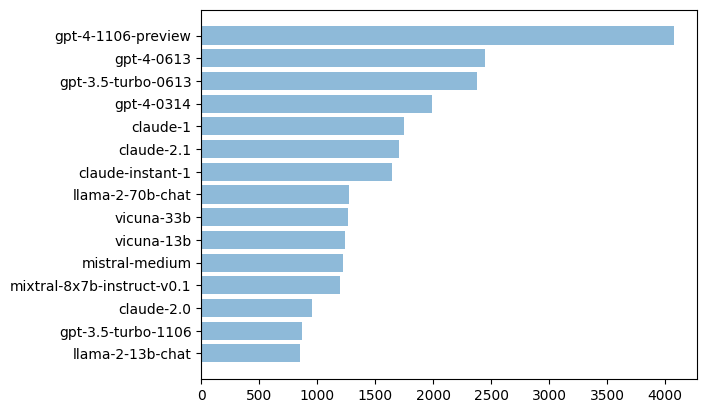

In [13]:
models = top_n.keys()
wins = top_n.values()

y_pos = np.arange(len(models))
plt.yticks(y_pos, models)
plt.barh(y_pos, wins, align="center", alpha=0.5)

## EDA

In [14]:
tagger = spacy.load("en_core_web_lg")

In [15]:
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def pos_tok(s):
    # tokenized_text = word_tokenize(s)
    # pos_tagged_text = tagger.tag(tokenized_text)
    s = str(s)
    doc = tagger(s)
    token_tag_list = []
    for token in doc:
        token_tag_list.append((token, token.pos_))
    return token_tag_list


def tag_seq_gen(token_tag_list):
    # collect sequence of tags
    # example:
    # PUNCT NOUN AUX PROPN ... DET PROPN
    tag_seq_list = []
    for token, tag in token_tag_list:
        tag_seq_list.append(tag)
    return tag_seq_list

token_tag_list = pos_tok(train_prompt_response_winner[10]["prompt"])

In [16]:
len(train_prompt_response_winner)

70912

### Length Analysis

- Are winning answers longer or shorter than the prompt? Are losing answers longer or shorter than the prompt? What about answers in a draw?
- How much longer are prompts/answers to each other?

In [19]:
try:
    df_n = pd.read_csv("lmsys-chatbot-arena/aux_files/df_w_lens.csv")
except:
    prompts = []
    prompt_lens = []
    
    answer_a = []
    answer_a_lens = []
    
    answer_b = []
    answer_b_lens = []
    
    winner_list = []
    
    for idx, e in tqdm.tqdm(enumerate(train_prompt_response_winner)):
        try:
            prompt_tokens = tagger(e["prompt"])
            prompts.append(e["prompt"])
            prompt_lens.append(len(list(prompt_tokens)))
        except:
            prompts.append(pd.NA)
            prompt_lens.append(pd.NA)
        try:
            model_a_response_len = len(list(tagger(e["model_a_response"])))
            answer_a.append(e["model_a_response"])
            answer_a_lens.append(model_a_response_len)
        except:
            answer_a.append(pd.NA)
            answer_a_lens.append(pd.NA)
        try:
            model_b_response_len = len(list(tagger(e["model_b_response"])))
            answer_b.append(e["model_b_response"])
            answer_b_lens.append(model_b_response_len)
        except:
            answer_b.append(pd.NA)
            answer_b_lens.append(pd.NA)
        try:
            winner = e["winner"]
            winner_list.append(winner)
        except:
            winner_list.append(pd.NA)

    df_n = pd.DataFrame()
    df_n["prompts"] = prompts
    df_n["prompt_lens"] = prompt_lens
    df_n["answer_a"] = answer_a
    df_n["answer_b"] = answer_b
    df_n["answer_a_lens"] = answer_a_lens
    df_n["answer_b_lens"] = answer_b_lens
    df_n["winner"] = winner_list
    
    df_n = df_n.dropna()
    df_n.to_csv("lmsys-chatbot-arena/aux_files/df_w_lens.csv")
    df_n

In [21]:
# remove any values < 1 and replace them with the mean
prompt_lens = np.array(df_n["prompt_lens"].tolist())
prompt_lens[~(prompt_lens >= 1)] = np.mean(prompt_lens)

answer_a_wins = df_n[(df_n["winner"] == "A")]["answer_a_lens"].tolist()
answer_b_wins = df_n[(df_n["winner"] == "B")]["answer_b_lens"].tolist()
total_answer_a_or_b_wins = np.array(answer_a_wins + answer_b_wins)
total_answer_a_or_b_wins[~(total_answer_a_or_b_wins >= 1)] = np.mean(total_answer_a_or_b_wins)

answer_a_lose = df_n[(df_n["winner"] == "B")]["answer_a_lens"].tolist()
answer_b_lose = df_n[(df_n["winner"] == "A")]["answer_b_lens"].tolist()
total_answer_a_or_b_lose = np.array(answer_a_lose + answer_b_lose)
total_answer_a_or_b_lose[~(total_answer_a_or_b_lose >= 1)] = np.mean(total_answer_a_or_b_lose)

answer_a_tied = df_n[(df_n["winner"] == "N")]["answer_a_lens"].tolist()
answer_b_tied = df_n[(df_n["winner"] == "N")]["answer_b_lens"].tolist()
total_tied_answers = np.array(answer_a_tied + answer_b_tied)
total_tied_answers[~(total_tied_answers >= 1)] = np.mean(total_tied_answers)

# get log scale vals
log_prompt_lens = np.log(prompt_lens)
log_total_answer_a_or_b_wins = np.log(total_answer_a_or_b_wins)
log_total_answer_a_or_b_lose = np.log(total_answer_a_or_b_lose)
log_total_tied_answers = np.log(total_tied_answers)

In [22]:
def plot_creater_2_x_2(x1, logx1, title1, title2, bins=60):
    fig = plt.figure(figsize=(12, 8))

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title(title1)
    ax1 = plt.hist(x1, bins=bins)

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title(title2)
    ax2 = plt.hist(logx1, bins=bins)

#### Prompt Length

                  0
count  70158.000000
mean      57.745061
std      175.746290
min        1.000000
25%        8.000000
50%       15.000000
75%       36.000000
max     3915.000000


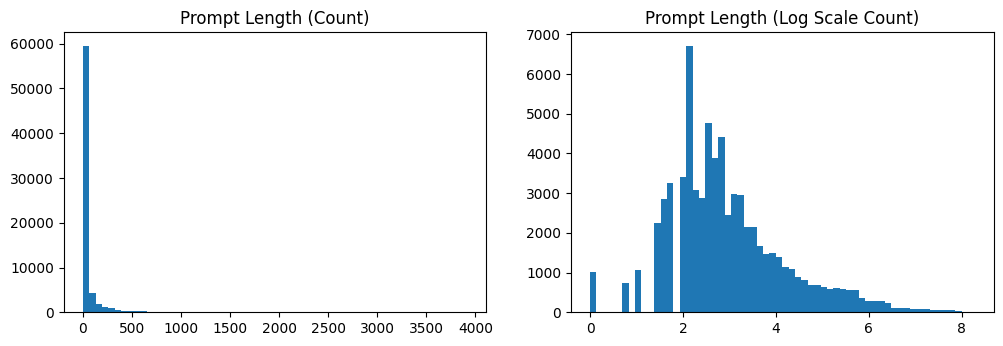

In [23]:
plot_creater_2_x_2(
    prompt_lens,
    log_prompt_lens,
    "Prompt Length (Count)",
    "Prompt Length (Log Scale Count)",
)

prompt_lens_desc = pd.DataFrame(prompt_lens)
print(prompt_lens_desc.describe())

#### Winning Answer Length

                  0
count  48881.000000
mean     245.689143
std      180.606081
min        1.000000
25%       92.000000
50%      228.000000
75%      360.000000
max     1682.000000


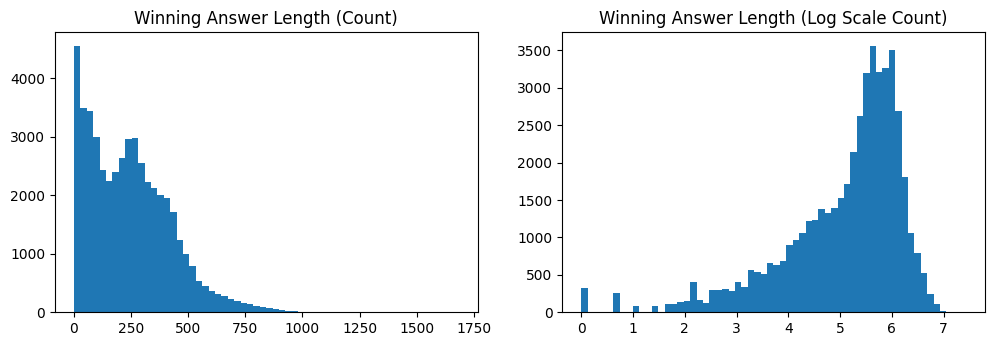

In [24]:
plot_creater_2_x_2(
    total_answer_a_or_b_wins,
    log_total_answer_a_or_b_wins,
    "Winning Answer Length (Count)",
    "Winning Answer Length (Log Scale Count)",
)

answer_win_lens_desc = pd.DataFrame(total_answer_a_or_b_wins)
print(answer_win_lens_desc.describe())

#### Losing Answer Length

(48881, 1)
                  0
count  48881.000000
mean     203.586138
std      162.860320
min        1.000000
25%       69.000000
50%      175.000000
75%      301.000000
max     1983.000000


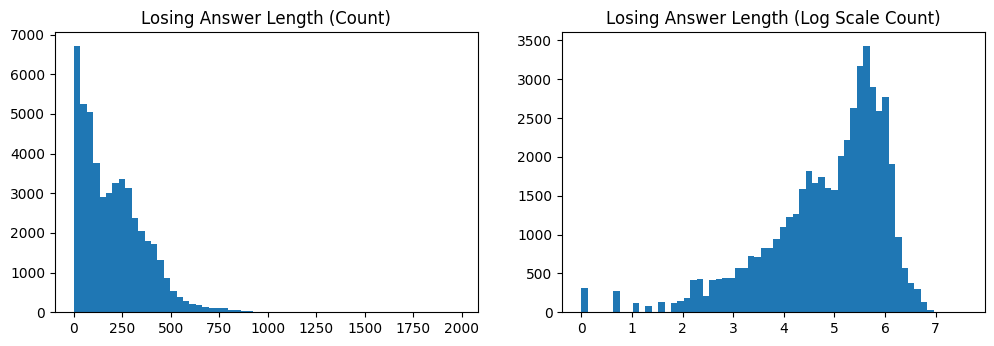

In [25]:
plot_creater_2_x_2(
    total_answer_a_or_b_lose,
    log_total_answer_a_or_b_lose,
    "Losing Answer Length (Count)",
    "Losing Answer Length (Log Scale Count)",
)

answer_lose_lens_desc = pd.DataFrame(total_answer_a_or_b_lose)
print(answer_lose_lens_desc.shape)
print(answer_lose_lens_desc.describe())

(42554, 1)
                  0
count  42554.000000
mean     205.157987
std      171.621314
min        1.000000
25%       62.000000
50%      174.000000
75%      308.000000
max     3788.000000


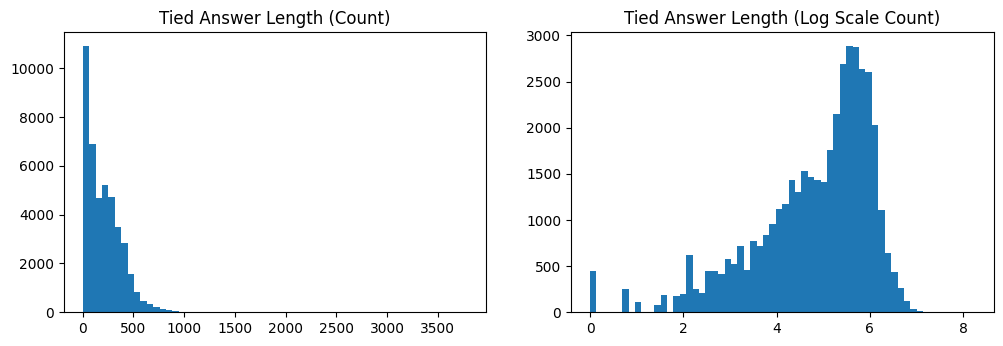

In [26]:
plot_creater_2_x_2(
    total_tied_answers,
    log_total_tied_answers,
    "Tied Answer Length (Count)",
    "Tied Answer Length (Log Scale Count)",
)

total_tied_answers_desc = pd.DataFrame(total_tied_answers)
print(total_tied_answers_desc.shape)
print(total_tied_answers_desc.describe())

#### Correlation Coefficient of Prompt Length vs Winner Answer Length

In [27]:
prompts_len_of_win_a = df_n[(df_n["winner"] == "A")]["prompt_lens"].tolist()
prompts_len_of_win_b = df_n[(df_n["winner"] == "B")]["prompt_lens"].tolist()

prompts_len_of_tie = df_n[(df_n["winner"] == "N")]["prompt_lens"].tolist()

answer_lens_of_a_win = df_n[(df_n["winner"] == "A")]["answer_a_lens"].tolist()
answer_lens_of_b_win = df_n[(df_n["winner"] == "B")]["answer_b_lens"].tolist()

answer_lens_of_a_tie = df_n[(df_n["winner"] == "N")]["answer_a_lens"].tolist()
answer_lens_of_b_tie = df_n[(df_n["winner"] == "N")]["answer_b_lens"].tolist()

prompt_t_lens = prompts_len_of_win_a + prompts_len_of_win_b
answer_t_lens = answer_lens_of_a_win + answer_lens_of_b_win

print("Prompt Length vs Winner Answer Length:\n" , np.corrcoef(prompt_t_lens , answer_t_lens))

# in a tie, both answers work, split them
print("Prompt Length vs Tie Answer Length (answer A):\n" , np.corrcoef(prompts_len_of_tie , answer_lens_of_a_tie))
print("Prompt Length vs Tie Answer Length (answer B):\n" , np.corrcoef(prompts_len_of_tie , answer_lens_of_b_tie))

Prompt Length vs Winner Answer Length:
 [[1.        0.1041611]
 [0.1041611 1.       ]]
Prompt Length vs Tie Answer Length (answer A):
 [[1.         0.14196895]
 [0.14196895 1.        ]]
Prompt Length vs Tie Answer Length (answer B):
 [[1.         0.14216932]
 [0.14216932 1.        ]]


### Tag Analysis

Given a winning/losing answer, what tags are not present in both - the prompt and the answer? Can we establish a relationship between between the a prompt and an answer that is selected (as preferred) through POS tags?

- Do winning answers "consume" certain tags? For example, do winning tags contain VERBs or NOUNs?
- Do losing answers have a common pattern of tags being "left behind"? For example, do losing answers leave behind entity tags, or VERBs?

In [28]:
success = 0
failed = 0

tags_prompt_winning_answer = []
tags_prompt_losing_answer = []
tags_prompt_ties = []

for idx, m in tqdm.tqdm(enumerate(train_prompt_response_winner)):

    prompt = m["prompt"]
    winner = m["winner"]

    try:
        token_tag_list_prompt = pos_tok(prompt)
        tag_seq_prompt = tag_seq_gen(token_tag_list_prompt)

        token_tag_list_A = pos_tok(m["model_a_response"])
        token_tag_list_B = pos_tok(m["model_b_response"])

        tag_seq_A = tag_seq_gen(token_tag_list_A)
        tag_seq_B = tag_seq_gen(token_tag_list_B)

        if winner == "A" and winner != "N":
            tags_prompt_winning_answer.append((tag_seq_prompt, tag_seq_A))
            tags_prompt_losing_answer.append((tag_seq_prompt, tag_seq_B))
        if winner == "B" and winner != " N":
            tags_prompt_winning_answer.append((tag_seq_prompt, tag_seq_B))
            tags_prompt_losing_answer.append((tag_seq_prompt, tag_seq_A))
        if winner == "N":
            tags_prompt_ties.append((tag_seq_prompt, tag_seq_A, tag_seq_B))

        success += 1

    except:
        failed += 1

# with open('lmsys-chatbot-arena/aux_files/tags_prompt_winning_answer.json', 'w') as fp:
#     json.dump(tags_prompt_winning_answer , fp)

# with open('lmsys-chatbot-arena/aux_files/tags_prompt_losing_answer.json', 'w') as fp:
#     json.dump(tags_prompt_losing_answer , fp)

# with open('lmsys-chatbot-arena/aux_files/tags_prompt_winning_answer.json', 'r') as fp:
#     tags_prompt_winning_answer = json.load(fp)

# with open('lmsys-chatbot-arena/aux_files/tags_prompt_losing_answer.json', 'r') as fp:
#     tags_prompt_losing_answer = json.load(fp)


success, failed, len(tags_prompt_ties), len(tags_prompt_winning_answer), len(
    tags_prompt_losing_answer
)

70912it [22:15, 53.10it/s]


(70158, 754, 21277, 48881, 48881)

{'SYM': 1244, 'INTJ': 2292, 'X': 2457, 'SPACE': 7382, 'NUM': 11031, 'ADV': 14464, 'SCONJ': 15091, 'PART': 15207, 'CCONJ': 16143, 'PROPN': 23346, 'ADJ': 29381, 'AUX': 31826, 'PRON': 32864, 'DET': 33966, 'ADP': 34580, 'PUNCT': 36267, 'VERB': 38228, 'NOUN': 43459}


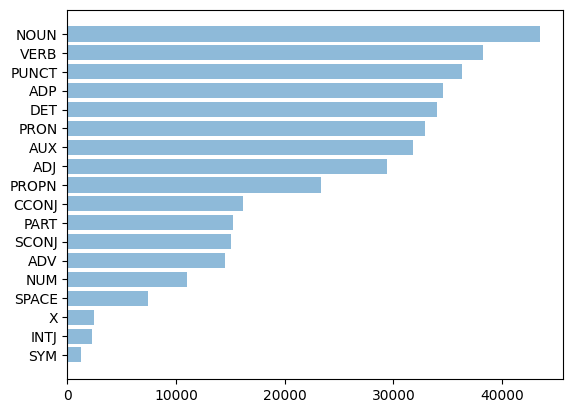

In [29]:
tag_intersections = []
for idx, e in enumerate(tags_prompt_winning_answer):
    ans_prompt_intersect = list(set(e[1]).intersection(set(e[0])))
    for tag in ans_prompt_intersect:
        tag_intersections.append(tag)

tag_count_intersections_map = zip()
k = list(Counter(tag_intersections).keys())
count = list(Counter(tag_intersections).values())
tag_count_intersections_map = dict(zip(k, count))
tag_count_intersections_map = {
    k: v for k, v in sorted(tag_count_intersections_map.items(), key=lambda item: item[1])
}

print(tag_count_intersections_map)

tags = tag_count_intersections_map.keys()
counts = tag_count_intersections_map.values()

y_pos = np.arange(len(tags))
plt.yticks(y_pos, tags)
plt.barh(y_pos, counts, align="center", alpha=0.5)
plt.show()

{'NOUN': 4311, 'SYM': 6755, 'VERB': 8421, 'INTJ': 8956, 'ADP': 11316, 'DET': 11475, 'PRON': 11764, 'PUNCT': 12072, 'AUX': 13507, 'PROPN': 15442, 'ADJ': 15931, 'NUM': 17561, 'X': 18600, 'SCONJ': 21992, 'PART': 25327, 'CCONJ': 26141, 'ADV': 27926, 'SPACE': 29823}


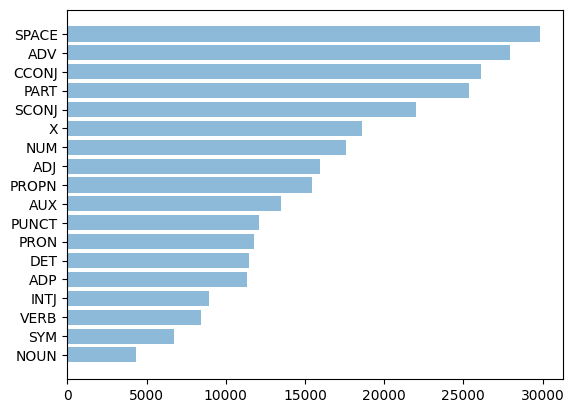

In [30]:
tag_residuals = []
for idx, e in enumerate(tags_prompt_winning_answer):
    ans_prompt_diff = list(set(e[1]) - set(e[0]))
    for tag in ans_prompt_diff:
        tag_residuals.append(tag)

tag_count_residuals_map = zip()
k = list(Counter(tag_residuals).keys())
count = list(Counter(tag_residuals).values())
tag_count_residuals_map = dict(zip(k, count))
tag_count_residuals_map = {
    k: v for k, v in sorted(tag_count_residuals_map.items(), key=lambda item: item[1])
}

print(tag_count_residuals_map)

tags = tag_count_residuals_map.keys()
counts = tag_count_residuals_map.values()

y_pos = np.arange(len(tags))
plt.yticks(y_pos, tags)
plt.barh(y_pos, counts, align="center", alpha=0.5)
plt.show()

In [31]:
df_n

,Unnamed: 0,prompts,prompt_lens,answer_a,answer_b,answer_a_lens,answer_b_lens,winner
0,0,Is it morally right to try to have a certain p...,17,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",527,136,A
1,2,What is the difference between marriage licens...,11,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,134,236,B
2,3,How can I get both of them as quick as possibl...,13,If you want to get both a marriage license and...,"In California, here are the general steps to o...",262,301,B
3,4,What is the minimal time to get them? 1 day or...,15,The minimal time to get a marriage license and...,The marriage license in California is issued i...,208,151,B
4,5,explain function calling. how would you call a...,11,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,199,422,N
...,...,...,...,...,...,...,...,...
70153,70907,are deterrents necessary in an ideal society?,8,"In an ideal society, deterrents like weapons m...",Deterrents are necessary in order to protect p...,342,54,A
70154,70908,how realistic is it for today's society to avo...,16,It is very difficult for today's societies to ...,"In today's society, it is not realistic to avo...",429,71,A
70155,70909,can you explain concisely why it is not feasib...,18,There are a few key reasons why stopping the u...,It is not feasible for us to stop using weapon...,356,68,A
70156,70910,"If a bait contains 0,0025% bromadiolon then ho...",22,Bromadiolone is a rodenticide which is most of...,"As an AI language model, I do not promote or c...",84,190,B


## Prepare Testing Data

In [150]:
df_test = pd.read_csv("lmsys-chatbot-arena/test.csv")
df_test.head()

,id,prompt,response_a,response_b
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran..."
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ..."
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p..."


In [130]:
df_test.shape

(3, 4)

In [153]:
test_prompt_response_winner = []
total_rows_processed = 0
rows_failed = 0
for row in df_test.iterrows():
    try:
        id_r = row[1]["id"]
        prompts = ast.literal_eval(row[1]["prompt"])
        response_a = ast.literal_eval(row[1]["response_a"])
        response_b = ast.literal_eval(row[1]["response_b"])

        for idx, p in enumerate(prompts):
            test_prompt_response_winner.append(
                {
                    "id":id_r,
                    "prompt": p,
                    "model_a_response": response_a[idx],
                    "model_b_response": response_b[idx],
                }
            )
        total_rows_processed += 1
    except Exception as e:
        rows_failed+= 1
        
total_rows_processed , rows_failed

(3, 0)

In [192]:
try:
    dft_ans = pd.read_csv("lmsys-chatbot-arena/aux_files/df_test.csv")
except:
    ids = []
    prompts = []
    answer_a = []
    answer_b = []
    
    for idx, e in tqdm.tqdm(enumerate(test_prompt_response_winner)):
        try:
            prompts.append(e["prompt"])
        except:
            prompts.append(pd.NA)
        try:
            answer_a.append(e["model_a_response"])
        except:
            answer_a.append(pd.NA)
        try:
            answer_b.append(e["model_b_response"])
        except:
            answer_b.append(pd.NA)
        try:
            ids.append(e["id"])
        except:
            ids.append(pd.NA)

    dft_ans = pd.DataFrame()
    
    dft_ans["id"] = ids
    dft_ans["prompts"] = prompts
    dft_ans["answer_a"] = answer_a
    dft_ans["answer_b"] = answer_b
    
    dft_ans = dft_ans.groupby('id').agg(lambda x : ' '.join(x)).reset_index()
    dft_ans.to_csv("lmsys-chatbot-arena/aux_files/df_test.csv")

4it [00:00, 29905.91it/s]


In [196]:
dft_ans

,id,prompts,answer_a,answer_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


## Preparing Data for Training

### Doc2Vec training data

In [221]:
testing_df = df_n.sample(frac=0.2, random_state=1).reset_index()
training_df = df_n[~df_n.index.isin(testing_df.index)]

In [242]:
print("Distribution of testing, col:" , testing_df['winner'].value_counts(normalize=True))
print("Distribution of training col:" , training_df['winner'].value_counts(normalize=True))

Distribution of testing, col: winner
A    0.357682
B    0.341078
N    0.301240
Name: proportion, dtype: float64
Distribution of training col: winner
A    0.352029
B    0.345277
N    0.302694
Name: proportion, dtype: float64


In [226]:
doc_lines = []
df_n.iloc[1]["prompts"] + " "
for row in tqdm.tqdm(training_df.iterrows()):
    prompt = str(row[1]["prompts"])
    winner = str(row[1]["winner"])
    answer_a = str(row[1]["answer_a"])
    answer_b = str(row[1]["answer_b"])
    if winner == "A":
        doc_lines.append(prompt + " " + answer_a)
    if winner == "B":
        doc_lines.append(prompt + " " + answer_b)
    if winner == "N":
        doc_lines.append(prompt + " " + answer_a)
        doc_lines.append(prompt + " " + answer_b)

56126it [00:00, 63216.90it/s]


In [326]:
cleaned_doc_lines = []
for line in tqdm.tqdm(doc_lines):
    # cleaned_line = gensim.utils.simple_preprocess(line)
    cleaned_line = [str(x[0]) for x in pos_tok(line)]
    cleaned_doc_lines.append(cleaned_line)

documents = [gensim.models.doc2vec.TaggedDocument(doc, [i]) for i, doc in enumerate(cleaned_doc_lines)]

100%|█████████████████████████████████████| 73115/73115 [12:22<00:00, 98.43it/s]


## Models

### Doc2Vec

In [457]:
d2v_v1 = Doc2Vec(vector_size=70, min_count=2, epochs=150 , window=6)
d2v_v1.build_vocab(documents)

2024-06-16 19:53:42,576 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d70,n5,w6,mc2,s0.001,t3>', 'datetime': '2024-06-16T19:53:42.576631', 'gensim': '4.3.2', 'python': '3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-06-16 19:53:42,610 : INFO : collecting all words and their counts
2024-06-16 19:53:42,610 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2024-06-16 19:53:42,870 : INFO : PROGRESS: at example #10000, processed 2861866 words (11039939 words/s), 90155 word types, 0 tags
2024-06-16 19:53:43,120 : INFO : PROGRESS: at example #20000, processed 5740219 words (11540736 words/s), 140877 word types, 0 tags
2024-06-16 19:53:43,375 : INFO : PROGRESS: at example #30000, processed 8543422 words (11010782 words/s), 183454 word types, 0 tags
2024-06-16 19:53:43,626 : INFO : PROGRESS: at example #40000, processed 11381899 words (11

In [458]:
d2v_v1.train(documents , total_examples=d2v_v1.corpus_count , epochs=d2v_v1.epochs)
d2v_v1.save("lmsys-chatbot-arena/aux_files/doc2vec_2_min_count_150_epochs_70_vector_size_6_window.d2v")

2024-06-16 19:53:45,816 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 183222 vocabulary and 70 features, using sg=0 hs=0 sample=0.001 negative=5 window=6 shrink_windows=True', 'datetime': '2024-06-16T19:53:45.816124', 'gensim': '4.3.2', 'python': '3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'train'}
2024-06-16 19:53:46,824 : INFO : EPOCH 0 - PROGRESS: at 10.65% examples, 1630333 words/s, in_qsize 6, out_qsize 0
2024-06-16 19:53:47,826 : INFO : EPOCH 0 - PROGRESS: at 21.33% examples, 1653606 words/s, in_qsize 5, out_qsize 0
2024-06-16 19:53:48,830 : INFO : EPOCH 0 - PROGRESS: at 32.33% examples, 1662733 words/s, in_qsize 6, out_qsize 0
2024-06-16 19:53:49,832 : INFO : EPOCH 0 - PROGRESS: at 43.56% examples, 1665664 words/s, in_qsize 6, out_qsize 0
2024-06-16 19:53:50,832 : INFO : EPOCH 0 - PROGRESS: at 54.38% examples, 1667961 words/s, in_qsize 6, out_qsize 0
20

In [490]:
# Test run
A = [str(x[0]) for x in pos_tok(testing_df.iloc[0]['prompts'])]
A = d2v_v1.infer_vector(doc_words = A)
A = np.array(A).reshape(1 , -1)

B = [str(x[0]) for x in pos_tok(testing_df.iloc[0]['prompts'])]
B = d2v_v1.infer_vector(doc_words = B)
B = np.array(B).reshape(1 , -1)

In [491]:
cosine_similarity(A , B)

array([[0.9957085]], dtype=float32)